### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt

### Read every cohort study file

In [2]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [3]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [4]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [5]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [6]:
for i in cohort_studies:
    cohort_studies[i]['Age']=cohort_studies_sub[i]['Age']

### Read harmonized mapping tables

In [7]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [8]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [9]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [10]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [11]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [12]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [13]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [14]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [15]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [16]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [17]:
# atn

In [18]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [19]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [20]:
# diag

### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [21]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [22]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts.keys()].dropna(axis=1).columns

In [23]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [24]:
cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT', 'TRABSCOR_bl': 'TRABSCOR'}, inplace=True)

# Plot the CSF biomarkers in different cohorts

In [25]:
# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in atn.index:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
#     for bioma, colo in zip(csf, colors):
# #         print(bioma, csf.index(bioma))
#         sns.histplot(cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
# #         axes[i, csf.index(bioma)].set_title(bioma.upper())
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
#     i+=1
    
# # plt.savefig("csf_biomarkers.png", dpi=300)

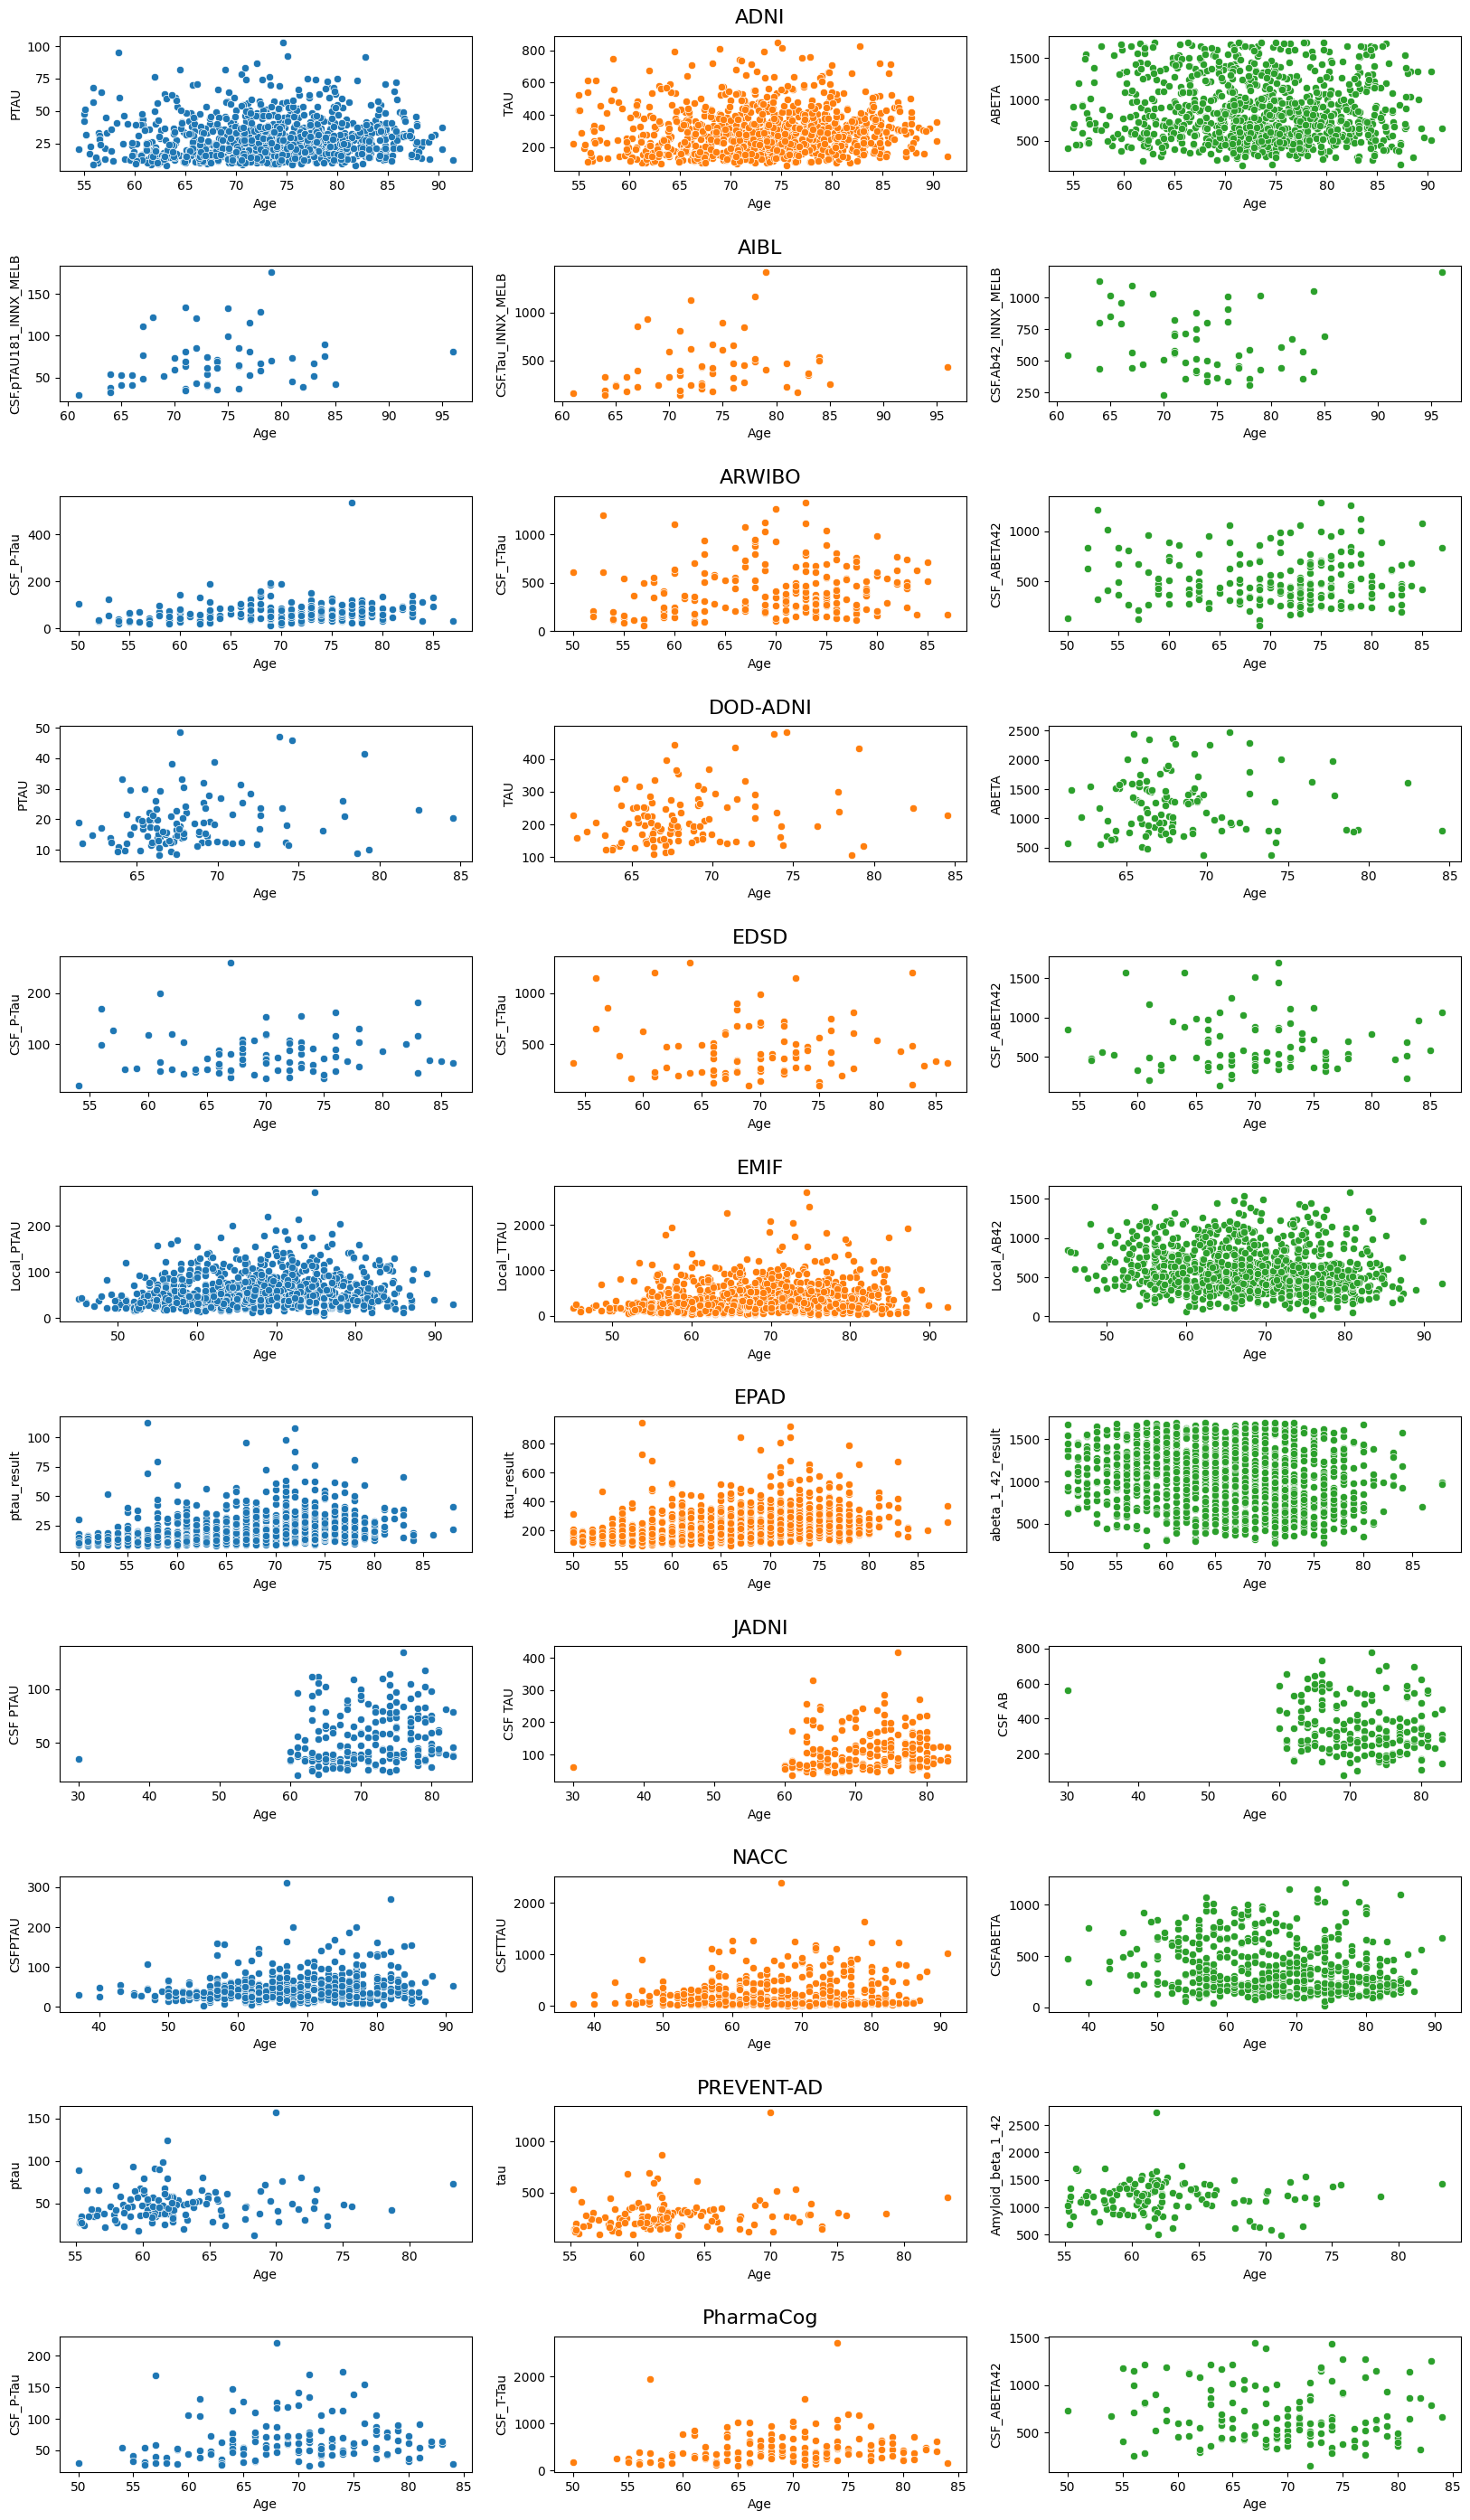

In [26]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, colo in zip(csf, colors):
#         print(bioma, csf.index(bioma))
        sns.scatterplot(x=cohort_studies[ind]['Age'], y=cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1
    
# plt.savefig("csf_biomarkers.png", dpi=300)

### Clustering CSF biomarkers, two classes, normal vs abnormal

### subset each cohort dataset based on the columns of interest for clustering 

In [27]:
mappings['csf'].loc[mappings['csf']['ADNI'] == 'PTAU', 'Feature'].item()

'pTau in CSF'

In [28]:
csf_names = mappings['csf'].loc[:2]['Feature'].to_list()

for i in atn.index:
    for csf_ in mappings['csf'].loc[:2][i]:
        cohort_studies[i].rename(columns={csf_: mappings['csf'].loc[mappings['csf'][i]==csf_, 'Feature'].item()}, inplace=True)

In [29]:
cohorts_csf = dict()

for i in atn.index:
    csf = mappings['csf'].iloc[:3]['Feature'].to_list()
    
    if i == 'NACC':
        cohorts_csf['NACC_ELISA'] = cohort_studies[i].loc[cohort_studies[i]['CSFTTMD']==1][csf + ["Diagnosis", "Age"]] # ELISA
        cohorts_csf['NACC_XMAP'] = cohort_studies[i].loc[cohort_studies[i]['CSFTTMD']==2][csf + ["Diagnosis", "Age"]] # xmap
        cohorts_csf['NACC_ELISA'] = cohorts_csf['NACC_ELISA'].dropna(subset=cohorts_csf['NACC_ELISA'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
        cohorts_csf['NACC_XMAP'] = cohorts_csf['NACC_XMAP'].dropna(subset=cohorts_csf['NACC_XMAP'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)

    
    elif i == 'EMIF':
        cohorts_csf['EMIF_ELISA'] = cohort_studies[i].loc[~(cohort_studies[i]['Studyname'].isin(['EDAR', 'Leuven', ]))][csf + ["Diagnosis", "Age"]] # INNOTEST ELISA
        cohorts_csf['EMIF_XMAP'] = cohort_studies[i].loc[(cohort_studies[i]['Studyname'].isin(['EDAR', 'Leuven', ]))][csf + ["Diagnosis", "Age"]] # xmap and not collected
        cohorts_csf['EMIF_ELISA'] = cohorts_csf['EMIF_ELISA'].dropna(subset=cohorts_csf['EMIF_ELISA'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
        cohorts_csf['EMIF_XMAP'] = cohorts_csf['EMIF_XMAP'].dropna(subset=cohorts_csf['EMIF_XMAP'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)

    else: 
        cohorts_csf[i] = cohort_studies[i][csf + ["Diagnosis", "Age"]]
        cohorts_csf[i] = cohorts_csf[i].dropna(subset=cohorts_csf[i].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)

In [30]:
for i in cohorts_csf:
    cohorts_csf[i]['Cohort'] = i
    cohorts_csf[i].drop(columns=['Age', 'Diagnosis'], inplace=True)

In [31]:
merged_dfs = pd.concat(cohorts_csf, ignore_index=True)

In [32]:
g1 = ['ADNI', 'EPAD']
g2 = ['AIBL', 'ARWIBO', 'EDSD', 'PREVENT-AD', 'PharmaCog', 'NACC_ELISA', 'EMIF_ELISA']
g3 = ['NACC_XMAP', 'EMIF_XMAP', 'DOD-ADNI', 'JADNI']

In [33]:
for i,j in enumerate([g1, g2, g3]): print(i,j)

0 ['ADNI', 'EPAD']
1 ['AIBL', 'ARWIBO', 'EDSD', 'PREVENT-AD', 'PharmaCog', 'NACC_ELISA', 'EMIF_ELISA']
2 ['NACC_XMAP', 'EMIF_XMAP', 'DOD-ADNI', 'JADNI']


In [34]:
merged_dfs = merged_dfs[['A-beta 1-42 in CSF', 'pTau in CSF', 'tTau in CSF', 'Cohort']]

Text(0.07, 0.5, 'Density')

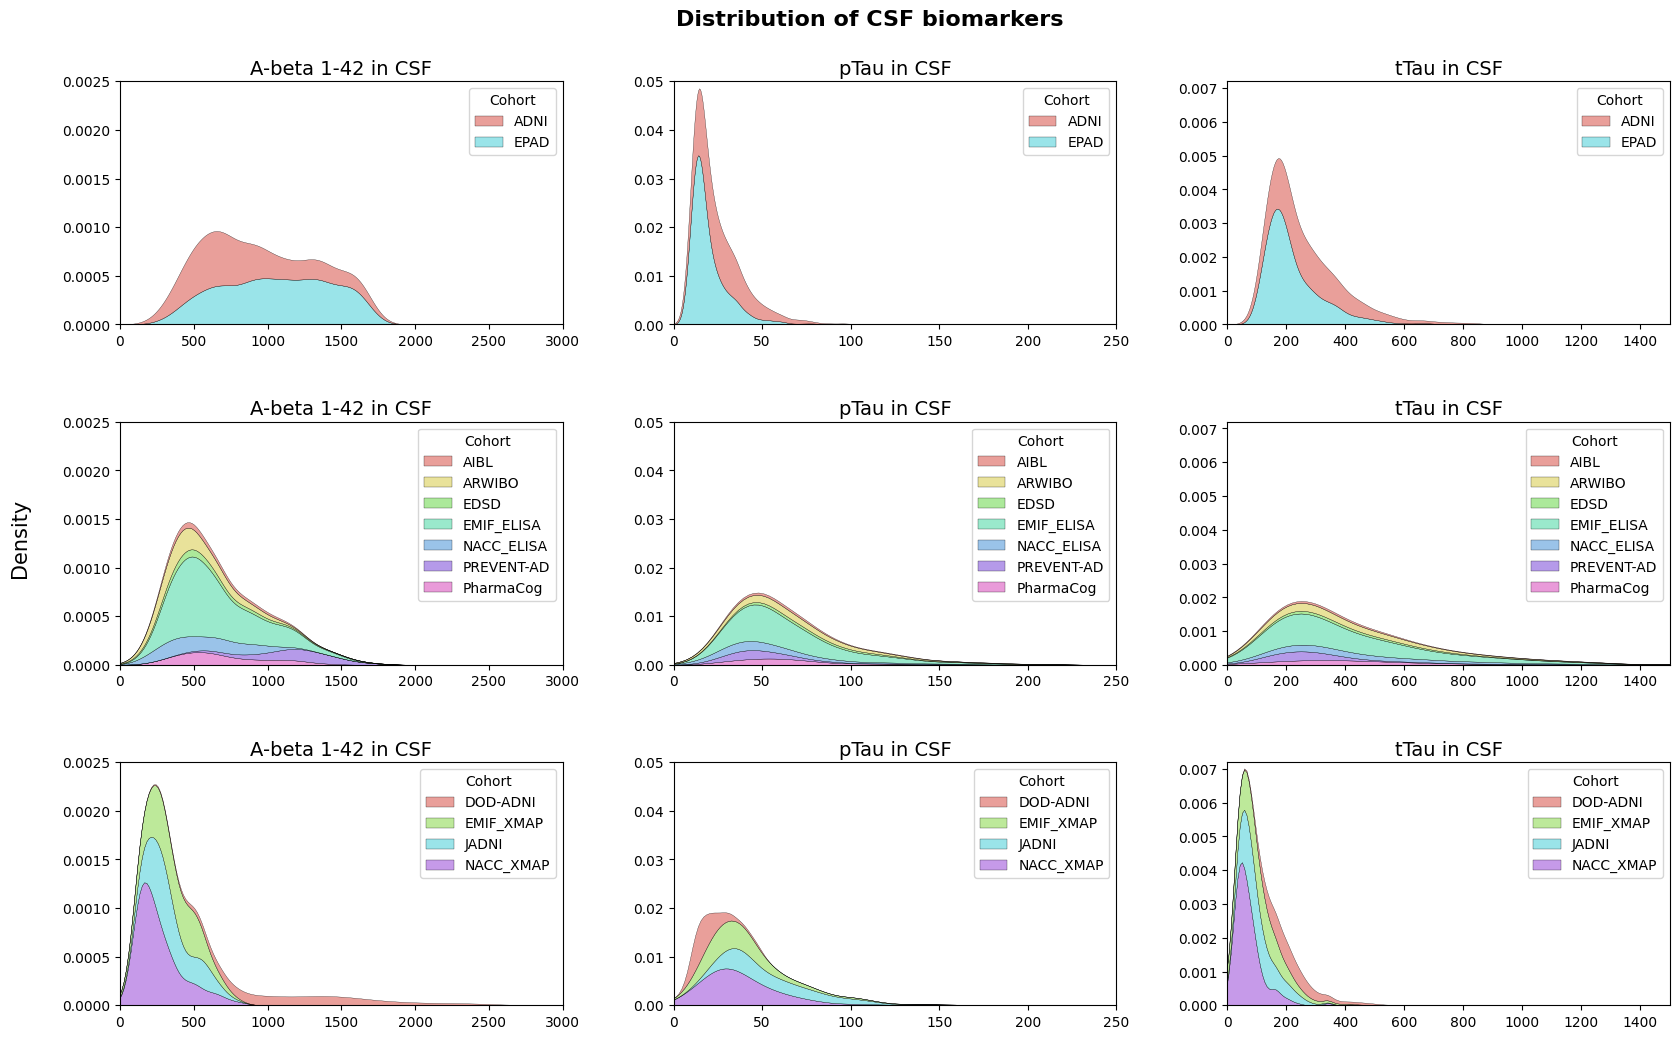

In [40]:
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(20, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.25)
# i=0
fig.suptitle(f"Distribution of CSF biomarkers", weight="bold", ha="center", fontsize=16, y=.94) 


for num, group in enumerate([g1, g2, g3]):
    palette = sns.color_palette('hls', n_colors=len(group))
    
    for pos, csf in enumerate(merged_dfs.columns[:3]):
#         max_val = max(merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf].to_list())
    
        merged_dfs.loc[merged_dfs['Cohort'].isin(g1)]
#         sns.histplot(x=merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf], ax=axes[num, pos], 
#                      hue=merged_dfs.loc[merged_dfs['Cohort'].isin(group)]['Cohort'], kde=True, palette=palette)
#         axes[num, pos].set_xlim([-10, (max_val+(0.02*max_val))])
        sns.kdeplot(x=merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf], ax=axes[num, pos], 
                     hue=merged_dfs.loc[merged_dfs['Cohort'].isin(group)]['Cohort'], palette=palette, 
                     multiple='stack', common_norm=True, alpha=0.6, linewidth=0.2)
    
        axes[num, pos].set_ylabel('')
        axes[num, pos].set_xlabel('')
        axes[num, pos].set_title(csf, fontsize=14, pad=5)
        
        axes[num, 0].set_xlim(0, 3001)
        axes[num, 0].set_ylim(0, 0.0025)
        axes[num, 1].set_xlim(0, 250)
        axes[num, 1].set_ylim(0, 0.05)
        axes[num, 2].set_xlim(0, 1500)
        axes[num, 2].set_ylim(0, 0.0072)

#         axes[num, pos].set_xlabel('csf', fontsize=14)
#         axes[num, pos].tick_params(axis='x', which='major', labelsize=12)
    
fig.text(0.07, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)
    
        
# plt.savefig("csf_biomarkers_new.png", dpi=400, bbox_inches='tight')        

<AxesSubplot: xlabel='A-beta 1-42 in CSF', ylabel='Density'>

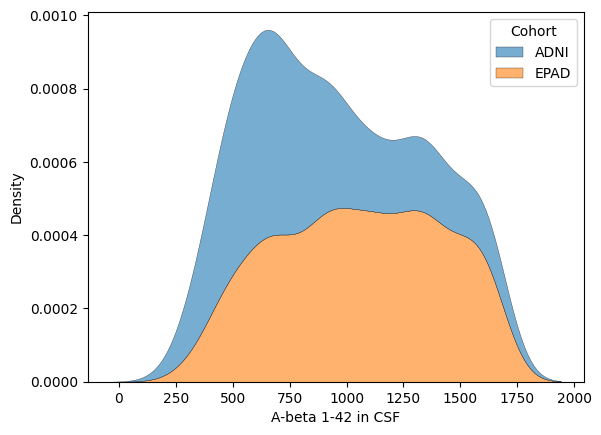

In [39]:
sns.kdeplot(x=merged_dfs.loc[merged_dfs['Cohort'].isin(g1)]['A-beta 1-42 in CSF'], 
                     hue=merged_dfs.loc[merged_dfs['Cohort'].isin(g1)]['Cohort'], 
                     multiple='stack', alpha=0.6, linewidth=0.2)

<AxesSubplot: xlabel='A-beta 1-42 in CSF', ylabel='Density'>

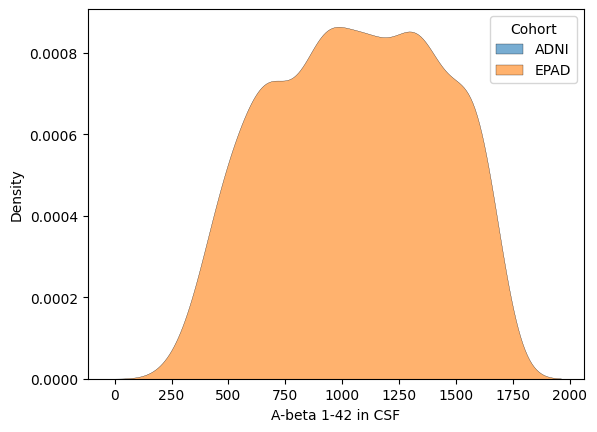

In [41]:
sns.kdeplot(x=merged_dfs.loc[merged_dfs['Cohort'].isin(['EPAD'])]['A-beta 1-42 in CSF'], 
                     hue=merged_dfs.loc[merged_dfs['Cohort'].isin(g1)]['Cohort'], 
                     multiple='stack', common_norm=True, alpha=0.6, linewidth=0.2)

<AxesSubplot: xlabel='A-beta 1-42 in CSF', ylabel='Density'>

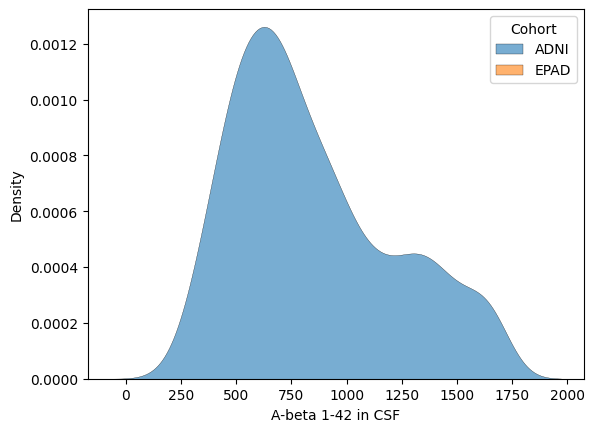

In [42]:
sns.kdeplot(x=merged_dfs.loc[merged_dfs['Cohort'].isin(['ADNI'])]['A-beta 1-42 in CSF'], 
                     hue=merged_dfs.loc[merged_dfs['Cohort'].isin(g1)]['Cohort'], 
                     multiple='stack', common_norm=True, alpha=0.6, linewidth=0.2)

In [39]:
merged_dfs.loc[merged_dfs['Cohort'].isin(g1)]['A-beta 1-42 in CSF']

0       1449.0
1        561.3
2        594.9
3        376.9
4       1044.0
         ...  
3735    1108.0
3736     494.4
3737    1175.0
3738     908.4
3739     654.3
Name: A-beta 1-42 in CSF, Length: 2254, dtype: float64

/home/ysalimi/my_env/lib/python3.8/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/ysalimi/my_env/lib/python3.8/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/ysalimi/my_env/lib/python3.8/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/ysalimi/my_env/lib/python3.8/site-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/home/ysalimi/my_env/lib/python3.8/site-packages/seaborn/distributions.p

Text(0.07, 0.5, 'Density')

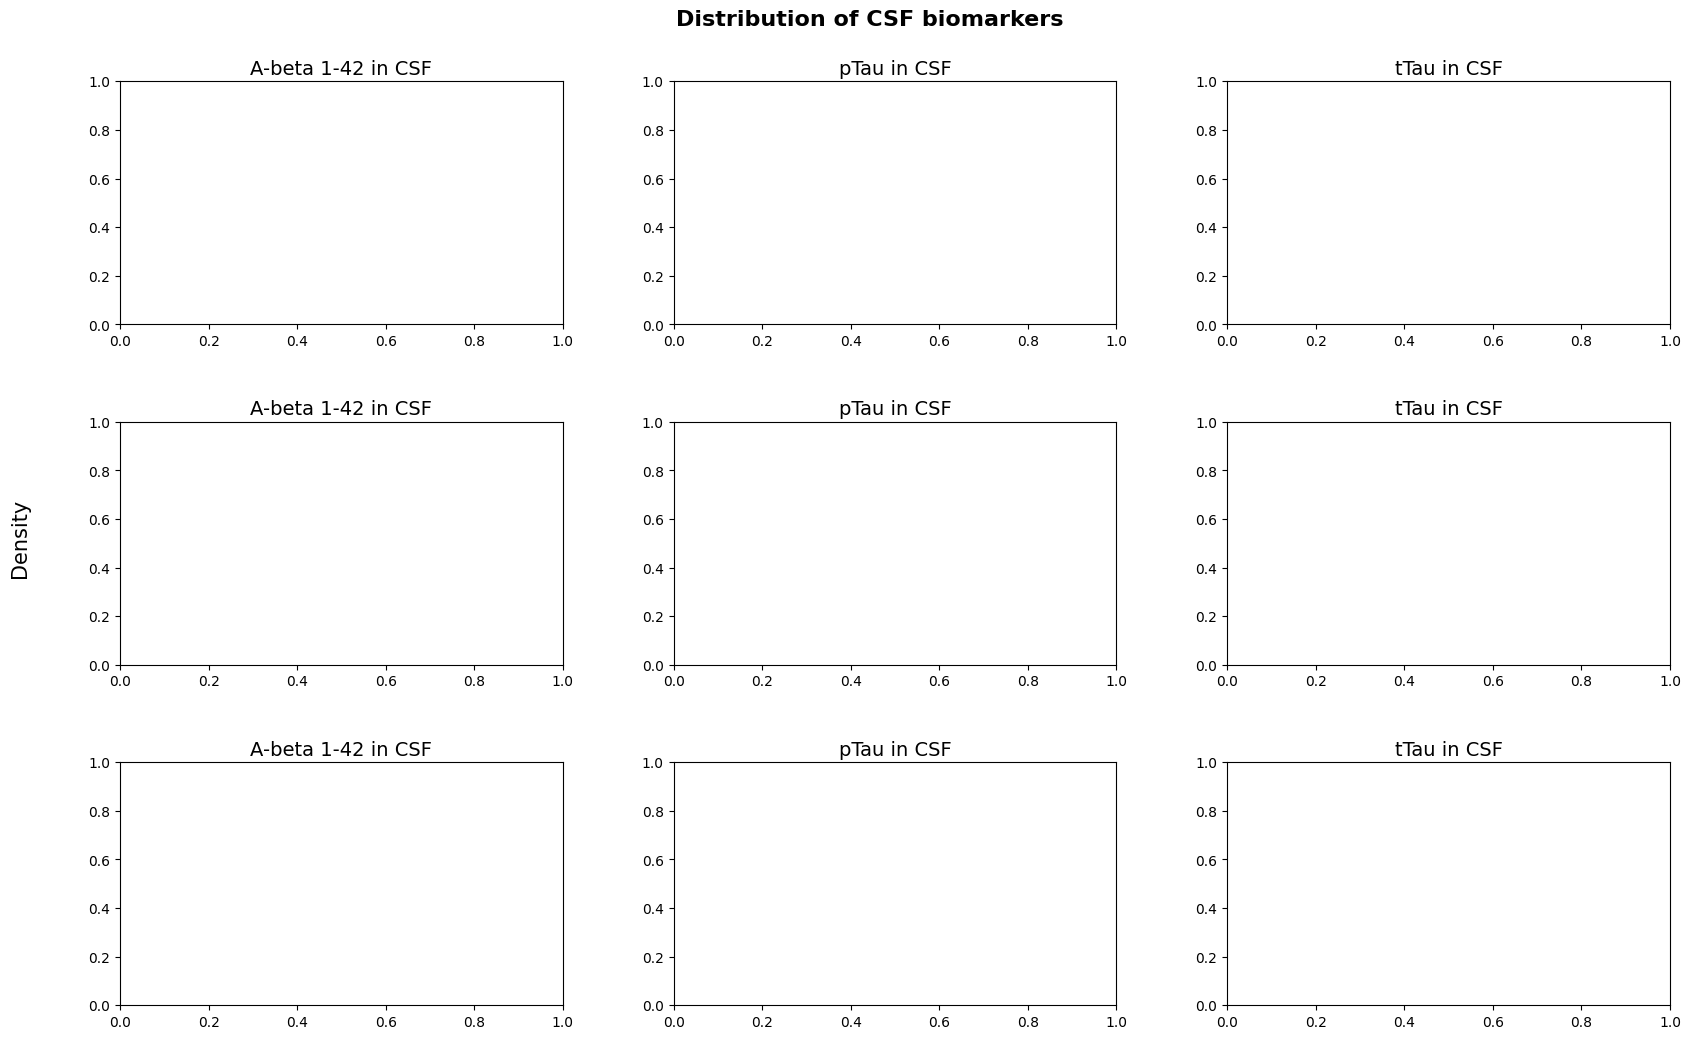

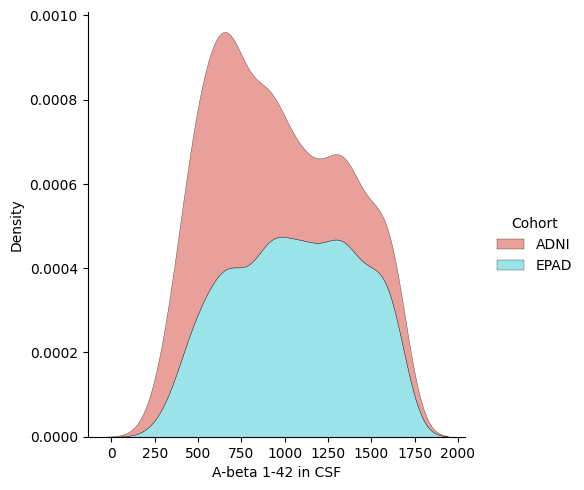

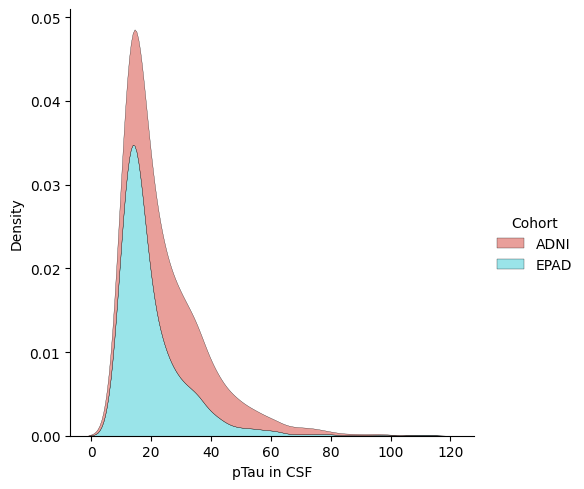

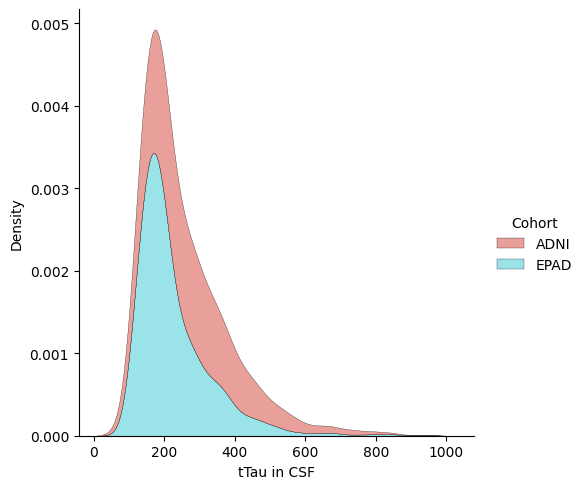

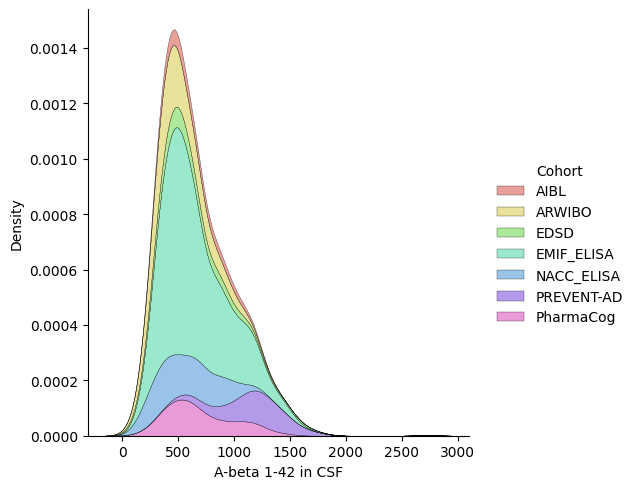

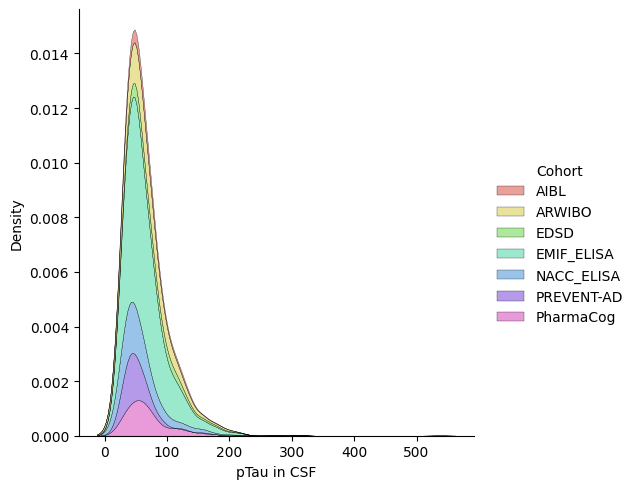

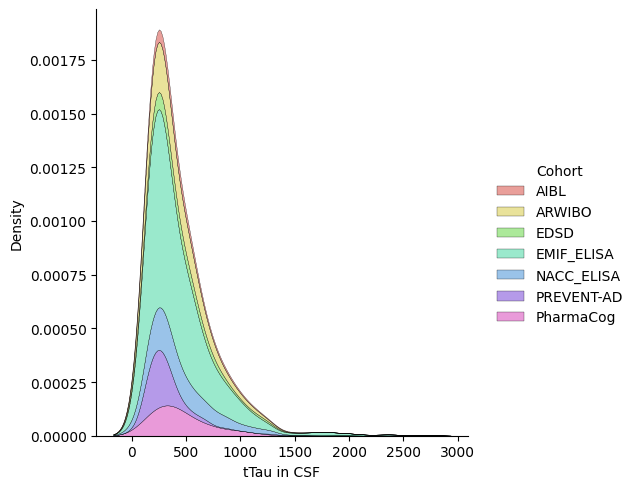

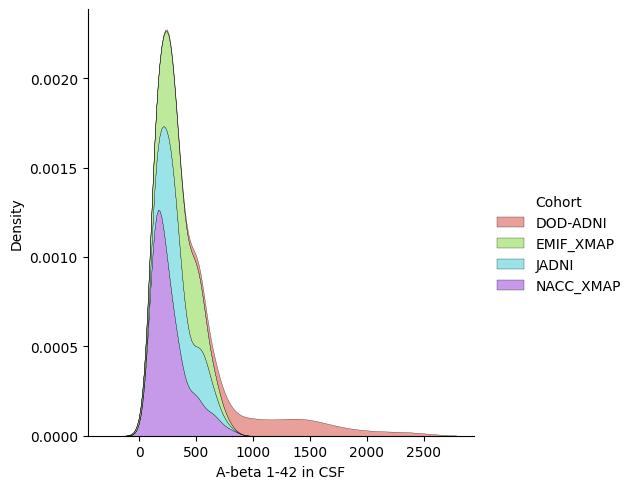

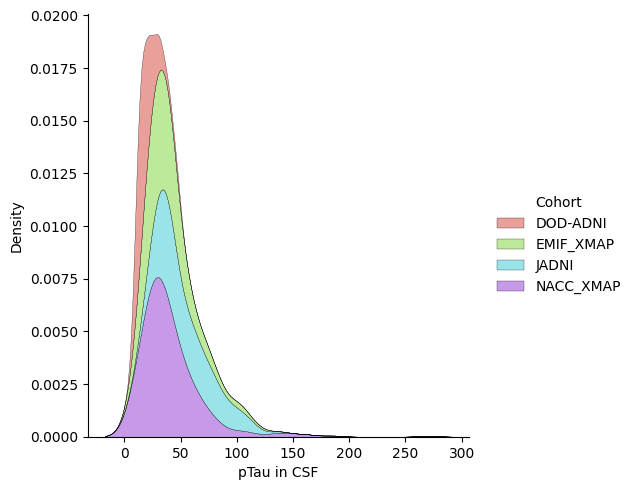

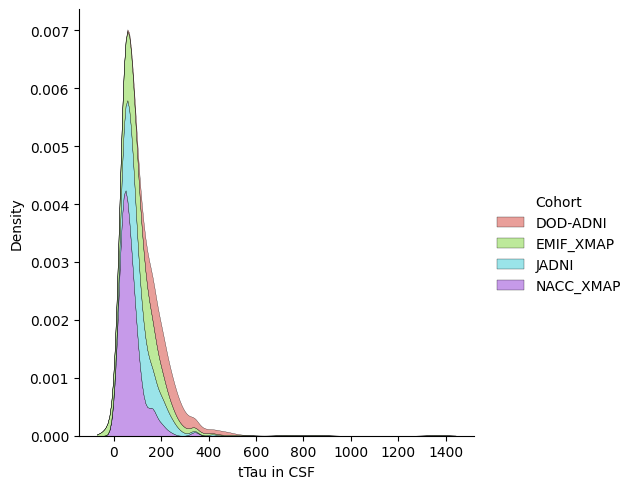

In [55]:
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(20, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.25)
# i=0
fig.suptitle(f"Distribution of CSF biomarkers", weight="bold", ha="center", fontsize=16, y=.94) 


for num, group in enumerate([g1, g2, g3]):
    palette = sns.color_palette('hls', n_colors=len(group))
    
    for pos, csf in enumerate(merged_dfs.columns[:3]):
#         max_val = max(merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf].to_list())
    
        merged_dfs.loc[merged_dfs['Cohort'].isin(g1)]
#         sns.histplot(x=merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf], ax=axes[num, pos], 
#                      hue=merged_dfs.loc[merged_dfs['Cohort'].isin(group)]['Cohort'], kde=True, palette=palette)
#         axes[num, pos].set_xlim([-10, (max_val+(0.02*max_val))])
        sns.displot(x=merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf], ax=axes[num, pos], 
                     hue=merged_dfs.loc[merged_dfs['Cohort'].isin(group)]['Cohort'], palette=palette, 
                     multiple='stack', alpha=0.6, linewidth=0.2, kind='kde')
    
        axes[num, pos].set_ylabel('')
        axes[num, pos].set_xlabel('')
        axes[num, pos].set_title(csf, fontsize=14, pad=5)
        
#         axes[num, 0].set_xlim(0, 3001)
#         axes[num, 0].set_ylim(0, 0.0025)
#         axes[num, 1].set_xlim(0, 250)
#         axes[num, 1].set_ylim(0, 0.05)
#         axes[num, 2].set_xlim(0, 1500)
#         axes[num, 2].set_ylim(0, 0.0072)

#         axes[num, pos].set_xlabel('csf', fontsize=14)
#         axes[num, pos].tick_params(axis='x', which='major', labelsize=12)
    
fig.text(0.07, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)
    
        
# plt.savefig("csf_biomarkers_new.png", dpi=400, bbox_inches='tight')        

Text(0.07, 0.5, 'Density')

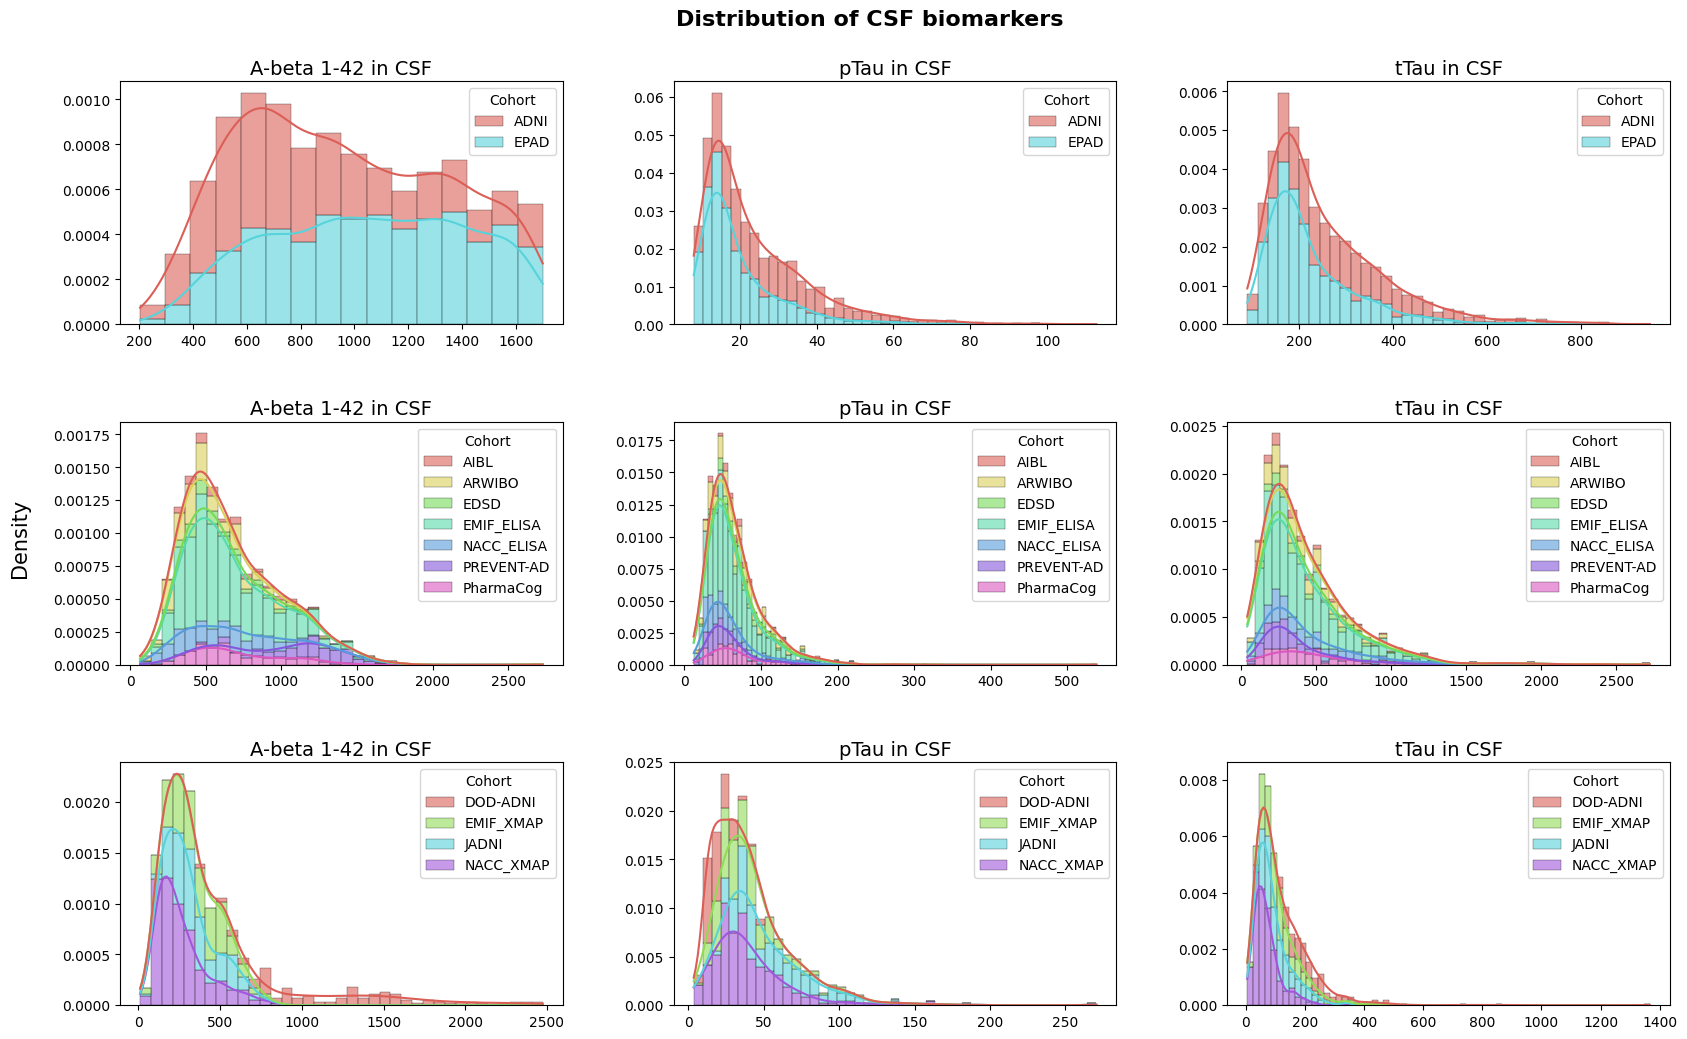

In [51]:
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(20, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.25)
# i=0
fig.suptitle(f"Distribution of CSF biomarkers", weight="bold", ha="center", fontsize=16, y=.94) 


for num, group in enumerate([g1, g2, g3]):
    palette = sns.color_palette('hls', n_colors=len(group))
    
    for pos, csf in enumerate(merged_dfs.columns[:3]):
#         max_val = max(merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf].to_list())
    
        merged_dfs.loc[merged_dfs['Cohort'].isin(g1)]
#         sns.histplot(x=merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf], ax=axes[num, pos], 
#                      hue=merged_dfs.loc[merged_dfs['Cohort'].isin(group)]['Cohort'], kde=True, palette=palette)
#         axes[num, pos].set_xlim([-10, (max_val+(0.02*max_val))])
        sns.histplot(x=merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf], ax=axes[num, pos], 
                     hue=merged_dfs.loc[merged_dfs['Cohort'].isin(group)]['Cohort'], palette=palette, 
                     multiple='stack', alpha=0.6, linewidth=0.2, kde=True, stat='density')
    
        axes[num, pos].set_ylabel('')
        axes[num, pos].set_xlabel('')
        axes[num, pos].set_title(csf, fontsize=14, pad=5)
        
#         axes[num, 0].set_xlim(0, 3001)
#         axes[num, 0].set_ylim(0, 0.0025)
#         axes[num, 1].set_xlim(0, 250)
#         axes[num, 1].set_ylim(0, 0.05)
#         axes[num, 2].set_xlim(0, 1500)
#         axes[num, 2].set_ylim(0, 0.0072)

#         axes[num, pos].set_xlabel('csf', fontsize=14)
#         axes[num, pos].tick_params(axis='x', which='major', labelsize=12)
    
fig.text(0.07, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)
    
        
# plt.savefig("csf_biomarkers_new.png", dpi=400, bbox_inches='tight')        

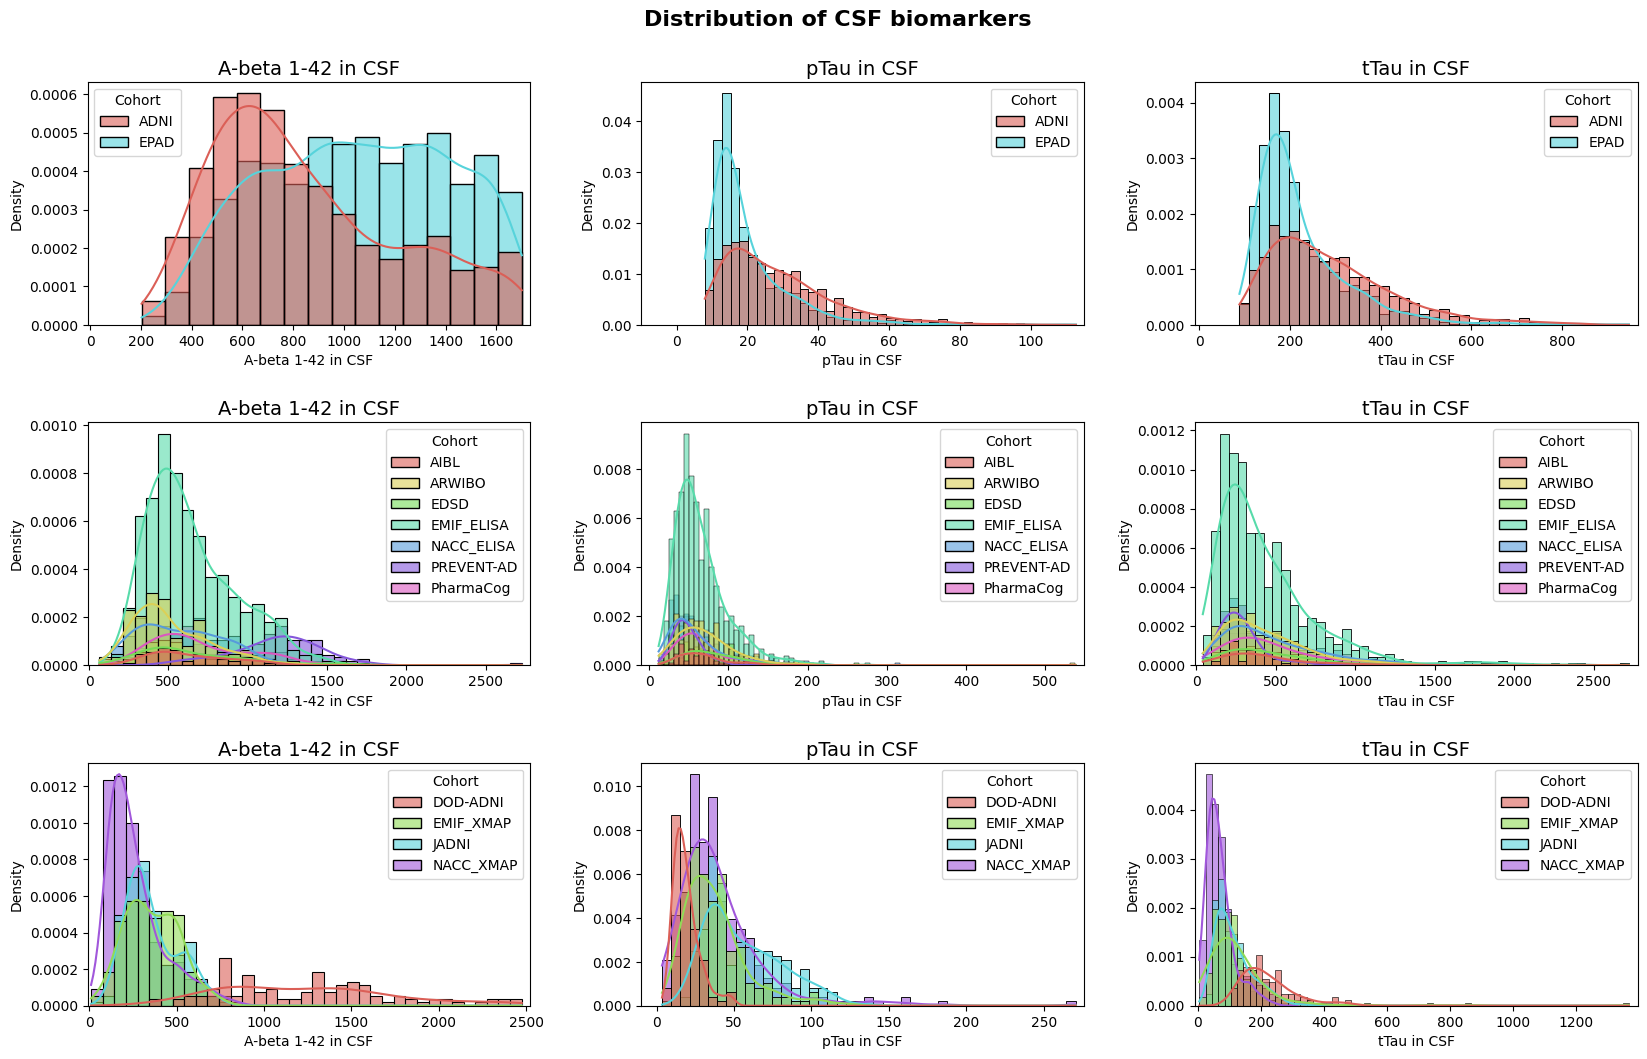

In [53]:
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(20, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.25)
# i=0
fig.suptitle(f"Distribution of CSF biomarkers", weight="bold", ha="center", fontsize=16, y=.94) 


for num, group in enumerate([g1, g2, g3]):
    palette = sns.color_palette('hls', n_colors=len(group))
    for pos, csf in enumerate(merged_dfs.columns[:3]):
        max_val = max(merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf].to_list())
    
        merged_dfs.loc[merged_dfs['Cohort'].isin(g1)]
        sns.histplot(x=merged_dfs.loc[merged_dfs['Cohort'].isin(group)][csf], ax=axes[num, pos], 
                     hue=merged_dfs.loc[merged_dfs['Cohort'].isin(group)]['Cohort'], kde=True, 
                     palette=palette, stat='density', alpha=0.6)
        axes[num, pos].set_xlim([-10, (max_val+(0.02*max_val))])
        axes[num, pos].set_title(csf, fontsize=14, pad=5)
    
# fig.text(0.07, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)
    

        
# plt.savefig("csf_biomarkers_checking.png", dpi=300, bbox_inches='tight')        